# Лабораторная работа №2
## Выполнил Буканов Н.К ПМ-21М
## Вариант 2

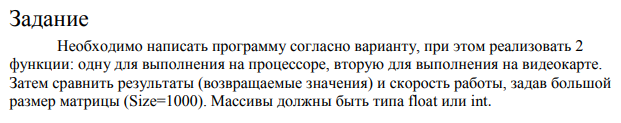
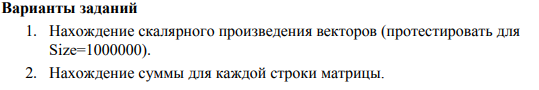

```c++
#include <cstdio>
#include <iostream>
#include <chrono>

constexpr size_t SIZE = 16384 * 3; 
constexpr size_t BLOCK_COUNT = 16384 * 3; 
constexpr size_t THREAD_PER_BLOCK = SIZE / BLOCK_COUNT;


template<typename T>
__global__ void sumMatrixRow(const float* matrix, T* result)
{
    unsigned int idx = threadIdx.x;
    unsigned int block_idx = blockIdx.x;

    idx = idx + (SIZE/BLOCK_COUNT) * block_idx;

    result[idx] = 0;
    for(size_t i=0; i < SIZE; i++)
    {
        result[idx] = result[idx] + matrix[idx * SIZE + i];
    }
}


template <typename T>
void sumMatrixRowCPU(const float* matrix, T* result)
{
  for(int idx = 0; idx < SIZE; idx++)
  {
    result[idx] = 0;
    for(size_t i=0; i < SIZE; i++)
    {
      result[idx] = result[idx] + matrix[idx * SIZE + i];
    }
  }
}

__host__ int main()
{
    auto* matrix = new float[SIZE * SIZE];
    auto* result = new float[SIZE];
    auto* result_1 = new float[SIZE];
    
    for (int i = 0; i < SIZE * SIZE; i++)
    {
        matrix[i] = int(i/SIZE);
        result[i%SIZE] = 0;
        result_1[i%SIZE] = 0;
    }

    float* gpu_matrix;
    float* gpu_result;
    

    cudaMalloc((void**)&gpu_matrix, sizeof(float) * SIZE * SIZE);
    cudaMemcpy(gpu_matrix, matrix, sizeof(float) * SIZE * SIZE, cudaMemcpyHostToDevice);
    
    cudaMalloc((void**)&gpu_result, sizeof(float) * SIZE);
    cudaMemcpy(gpu_result, result, sizeof(float) * SIZE, cudaMemcpyHostToDevice);

    dim3 gridSize = dim3(BLOCK_COUNT, 1, 1); //Размер используемой сетки
    dim3 blockSize = dim3(THREAD_PER_BLOCK, 1, 1); //Размер используемого блока

    cudaEvent_t kernel_start;
    cudaEventCreate(&kernel_start);
    cudaEventRecord(kernel_start, nullptr);

    sumMatrixRow<<<gridSize, blockSize>>>(gpu_matrix, gpu_result);

    cudaEvent_t syncEvent;
    cudaEventCreate(&syncEvent);
    cudaEventRecord(syncEvent, nullptr);
    cudaEventSynchronize(syncEvent);
    float time;
    cudaEventElapsedTime(&time, kernel_start, syncEvent);

    cudaMemcpy(result, gpu_result, sizeof(float) * SIZE, cudaMemcpyDeviceToHost);

    std::cout << "GPU Elapsed time " << time << std::endl;
    auto t1 = std::chrono::high_resolution_clock::now();
    sumMatrixRowCPU(matrix, result_1);
    auto t2 = std::chrono::high_resolution_clock::now();

    std::cout << "CPU Elapsed time " << std::chrono::duration_cast<std::chrono::milliseconds>(t2 - t1).count() <<std::endl;

    for (int i = 0; i < 10; i++)
    {
      printf("Element #%i: %.1f %1.f\n", i , result[i], result_1[i]);
    }

    // Освобождаем ресурсы
    cudaEventDestroy(syncEvent);
    cudaFree(gpu_matrix);
    cudaFree(gpu_result);
    delete[] result;
    delete[] result_1;
    delete[] matrix;
}
```

In [5]:
! ../cmake-build-debug/lab2

GPU Elapsed time 580.053
CPU Elapsed time 6799
Element #0: 0.0 0
Element #1: 49152.0 49152
Element #2: 98304.0 98304
Element #3: 147456.0 147456
Element #4: 196608.0 196608
Element #5: 245760.0 245760
Element #6: 294912.0 294912
Element #7: 344064.0 344064
Element #8: 393216.0 393216
Element #9: 442368.0 442368
